# Visualize measurment results

In [443]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import spearmanr

In [444]:
data = pd.read_excel("/home/fritz/Pictures/olympus_undistortion_test/Measurments.ods")
data["ID"] = data.set_index(["Tag", "Rank"]).index.factorize()[0] + 1

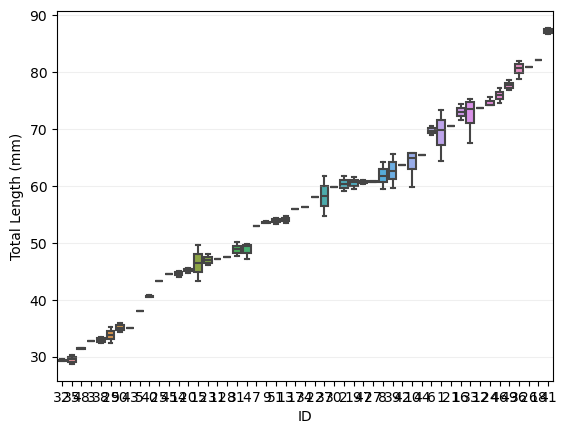

In [459]:
grouped = (
    data.loc[:, ["ID", "Total Length (mm)"]]
    .groupby(["ID"])
    .median()
    .sort_values(by="Total Length (mm)")
)

plt.gca().yaxis.grid(True, alpha=0.2)
sns.boxplot(data=data, x="ID", y="Total Length (mm)", order=grouped.index)
plt.show()

In [460]:
mean_error = []
for i in data.ID.unique():
    error = np.var(data[data["ID"] == i]["Total Length (mm)"])
    mean_error.append(error)
print(np.mean(error))

0.3069159999999983


## Compare to manual measurements

In [461]:
# Taking advantage of numpy
def distance_from_diagonal(diagonal_extremes, point):
    u = (
        diagonal_extremes[1][0] - diagonal_extremes[0][0],
        diagonal_extremes[1][1] - diagonal_extremes[0][1],
    )
    v = (point[0] - diagonal_extremes[0][0], point[1] - diagonal_extremes[0][1])
    return np.cross(u, v) / np.linalg.norm(u)

In [462]:
datasheet = "/home/fritz/Documents/0_FieldWork/0_Buston_Rueger_PNG/3_Field_Documents/TranslocationExperiment_DataEntry_20240731.xlsx"

datasheet = pd.ExcelFile(datasheet)
sheets = datasheet.sheet_names  # see all sheet names
datasheet = pd.concat(
    [pd.read_excel(datasheet, sheet_name=sheet) for sheet in sheets], axis=0
).reset_index()

mask = pd.notna(
    datasheet["Rank_2_SL"]
)  # Filter to only include values at which sensors where deployed
datasheet = datasheet[mask]

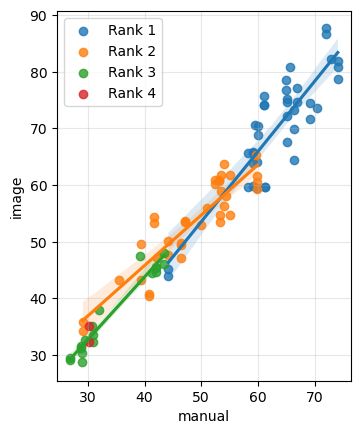

In [463]:
manual = []
image = []
tag = []
id = []
rank = []

for index, row in data.iterrows():
    column_name = "Rank_" + str(row["Rank"]) + "_TL"
    manual_measurement = datasheet[datasheet["Tag"] == "RB" + str(row["Tag"])][
        column_name
    ].to_numpy()[0]
    image_measurement = row["Total Length (mm)"]
    manual = np.append(manual, float(manual_measurement))
    image = np.append(image, float(image_measurement))
    tag.append("RB" + str(row["Tag"]))
    id.append(row["ID"])
    rank.append(row["Rank"])


outdf = pd.DataFrame(
    np.c_[tag, id, rank, manual, image],
    columns=["tag", "id", "rank", "manual", "image"],
)
outdf["manual"] = outdf["manual"].astype(float)
outdf["image"] = outdf["image"].astype(float)
outdf["diff"] = np.sqrt(np.power(outdf["manual"] - outdf["image"], 2))

errors = []
for pt in zip(outdf["manual"], outdf["image"]):
    errors = np.append(errors, distance_from_diagonal([[0, 0], [400, 400]], pt))
outdf["error"] = errors

## Plot
fig, ax = plt.subplots()
for i, rank in enumerate(np.unique(outdf["rank"])):
    sns.regplot(
        data=outdf[outdf["rank"] == rank],
        x="manual",
        y="image",
        ax=ax,
        label="Rank " + str(rank),
    )

ax.legend()
ax.grid(alpha=0.3)
ax.set_aspect("equal")
plt.show()

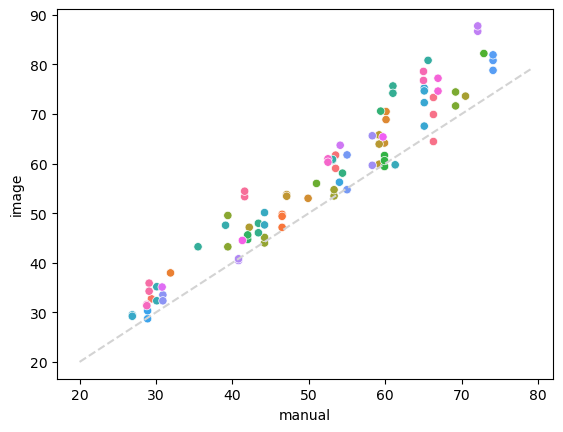

In [464]:
sns.scatterplot(data=outdf, x="manual", y="image", hue="id", legend=False)
sns.lineplot(
    x=np.arange(20, 80, 1), y=np.arange(20, 80, 1), linestyle="--", color="lightgray"
)
plt.show()

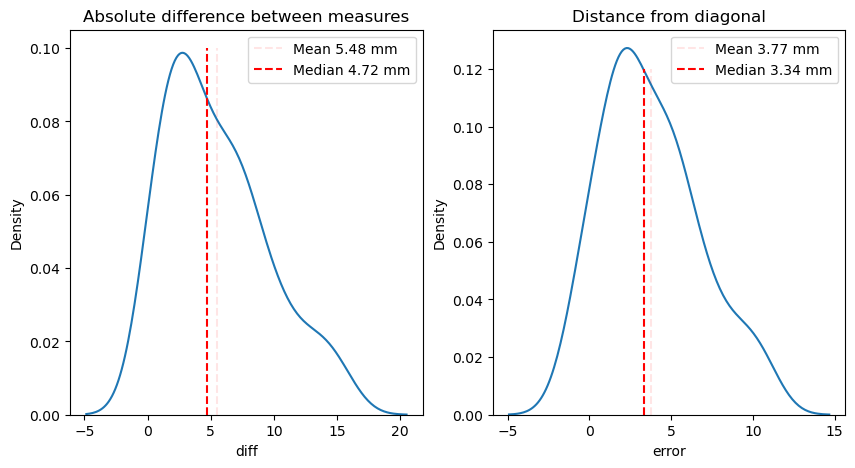

In [469]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = outdf.describe()
error_mean = d["error"]["mean"]
error_std = d["error"]["std"]
error_median = d["error"]["50%"]

diff_mean = d["diff"]["mean"]
diff_std = d["diff"]["std"]
diff_median = d["diff"]["50%"]

sns.kdeplot(data=outdf, x="diff", ax=ax[0])

ax[0].vlines(
    diff_mean,
    0,
    0.10,
    color="r",
    linestyle="--",
    alpha=0.1,
    label=str("Mean {} mm".format(np.round(diff_mean, 2))),
)

ax[0].vlines(
    diff_median,
    0,
    0.10,
    color="r",
    linestyle="--",
    label=str("Median {} mm".format(np.round(diff_median, 2))),
)

ax[0].legend()
ax[0].set_title("Absolute difference between measures")

sns.kdeplot(data=outdf, x="error", ax=ax[1])

ax[1].vlines(
    error_mean,
    0,
    0.12,
    color="r",
    linestyle="--",
    alpha=0.1,
    label=str("Mean {} mm".format(np.round(error_mean, 2))),
)

ax[1].vlines(
    error_median,
    0,
    0.12,
    color="r",
    linestyle="--",
    label=str("Median {} mm".format(np.round(error_median, 2))),
)

ax[1].legend()
ax[1].set_title("Distance from diagonal")
plt.show()

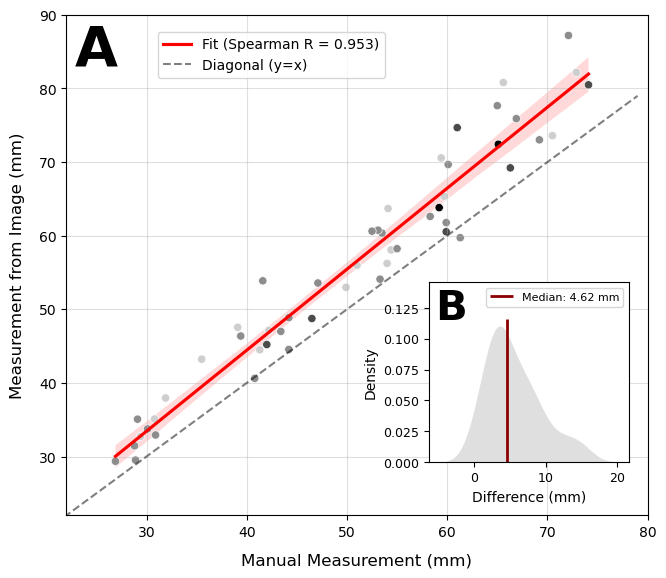

In [476]:
# Mean values for image measures
image = (
    outdf.groupby("id")["image"]
    .agg([np.min, np.max, np.mean, "size"])
    .reset_index()["mean"]
)
manual = (
    outdf.groupby("id")["manual"].agg([np.min, np.max, np.mean]).reset_index()["mean"]
)
diff = outdf.groupby("id")["diff"].agg([np.min, np.max, np.mean]).reset_index()["mean"]
count = outdf.groupby("id")["image"].agg(["size"]).reset_index()["size"]

id = outdf.groupby("id")["manual"].agg([np.min, np.max, np.mean]).reset_index()["id"]
rank = outdf.groupby("id")["rank"].agg(["first"]).reset_index()["first"]

mval = pd.DataFrame(
    np.c_[id, rank, manual, image, diff, count],
    columns=["id", "rank", "manual", "image", "diff", "count"],
)
mval["manual"] = mval["manual"].astype(float)
mval["image"] = mval["image"].astype(float)
mval["diff"] = mval["diff"].astype(float)
mval["count"] = mval["count"].astype(int)

# Correlation
result = spearmanr(outdf["manual"], outdf["image"])

fig, ax = plt.subplots(figsize=(7.5, 6.5))

sns.regplot(
    data=mval,
    x="manual",
    y="image",
    scatter=False,
    scatter_kws={"color": "black"},
    line_kws={"color": "red"},
    label=str("Fit (Spearman R = {})".format(np.round(result.statistic, 3))),
    ax=ax,
)

# Limit colormap to exclude low range white
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Greys
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

sns.scatterplot(
    data=mval,
    x="manual",
    y="image",
    hue=mval["count"],
    palette=cmap,
    ax=ax,
    legend=False,
)

sns.lineplot(
    x=np.arange(20, 80, 1),
    y=np.arange(20, 80, 1),
    linestyle="--",
    color="black",
    alpha=0.5,
    label="Diagonal (y=x)",
    ax=ax,
)

ax.legend(loc="best", bbox_to_anchor=(0.16, 0.0, 0.4, 0.98), fontsize=10)
ax.set_xlabel("Manual Measurement (mm)", fontsize=12, labelpad=10)
ax.set_ylabel("Measurement from Image (mm)", fontsize=12, labelpad=10)
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)
ax.set_ylim(22, 90)
ax.set_xlim(22, 80)
ax.grid(alpha=0.4)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
# ax.text(xmin+2*(xmax/100), ymax-8*(ymax/100), "A", fontsize=40, fontweight=900)

# Inset Plot
axins = inset_axes(
    ax,
    width=2,
    height=1.8,
    bbox_to_anchor=(0.68, -0.02, 0.3, 0.5),
    bbox_transform=ax.transAxes,
)

sns.kdeplot(data=mval, x="diff", ax=axins, color="gray", fill=True, linewidth=0)
xmin, xmax = axins.get_xlim()
ymin, ymax = axins.get_ylim()

axins.vlines(
    np.round(np.median(mval["diff"]), 2),
    0,
    ymax,
    color="darkred",
    linestyle="-",
    linewidth=2, 
    label=str("Median: {} mm".format(np.round(np.median(mval["diff"]), 2))),
)

axins.legend(fontsize=8)
axins.set_xlabel("Difference (mm)", fontsize=10)
axins.set_ylabel("Density", fontsize=10)
plt.setp(axins.get_xticklabels(), fontsize=9)
plt.setp(axins.get_yticklabels(), fontsize=9)
axins.patch.set_facecolor("white")
# axins.patch.set_alpha(0.9)
axins.set_ylim(ymin, ymax + 0.03)
# axins.text(xmin+6*(xmax/100), ymax-5*(ymax/100), "B", fontsize=30, fontweight=900)

labels = ["A", "B"]
sizes = [40, 30]
for i, a in enumerate([ax, axins]):
    a.annotate(
        labels[i],
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(+0.15, -0.15),
        textcoords="offset fontsize",
        fontsize=sizes[i],
        fontweight=900,
        verticalalignment="top",
        fontfamily="sans",
        bbox=dict(facecolor="1", edgecolor="none", pad=0),
    )

plt.show()

In [441]:
mval

,id,rank,manual,image,diff,count
0,1,1,66.3,69.215667,4.157667,3
1,10,1,59.2,63.816500,4.616500,4
2,11,2,42.2,47.145000,4.945000,1
3,12,1,70.5,73.593000,3.093000,1
4,13,2,53.3,54.094000,0.794000,2
5,14,1,44.2,44.546000,0.561000,2
6,15,2,39.4,46.370500,6.970500,2
7,16,1,69.2,73.024000,3.824000,2
8,17,2,51.0,55.989000,4.989000,1
9,18,1,72.9,82.188000,9.288000,1
